# 1. EDA

## 1.1 Load Datasets

In [84]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [85]:
# Import dataset
df_train = pd.read_csv("data/train.csv", index_col="PassengerId")
df_test = pd.read_csv("data/test.csv", index_col="PassengerId")
df = pd.concat([df_train, df_test], sort=True)
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
df_train.head()

Train shape: (891, 11)
Test shape: (418, 10)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- **Passenger Id**: the unique id of the row
- **Survived**: target variable
    - 1 = Survived
    - 0 = Not Survived
- **Pclass**: categorical feature describing passenger class
    - 1 = Upper Class
    - 2 = Middle Class
    - 3 = Lower Class
- **Name, Sex and Age** are self-explanatory
- **SibSp** is the total number of the passengers' siblings and spouse
- **Parch** is the total number of passengers' parents and children
- **Ticket** is the ticket number of the passenger
- **Fare** is the passenger fare
- **Cabin** is the cabin nuber ofthe passenger
- **Embarked** is the port of embarkation
    - C = Cherbourg
    - Q = Queenstown
    - S = Southampton

In [86]:
# Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       1046 non-null   float64
 1   Cabin     295 non-null    object 
 2   Embarked  1307 non-null   object 
 3   Fare      1308 non-null   float64
 4   Name      1309 non-null   object 
 5   Parch     1309 non-null   int64  
 6   Pclass    1309 non-null   int64  
 7   Sex       1309 non-null   object 
 8   SibSp     1309 non-null   int64  
 9   Survived  891 non-null    float64
 10  Ticket    1309 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


We have some missing values we will deal with later in the notebook

In [87]:
# Check basic statistics
df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [88]:
df_test.describe()

,Pclass,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.841838,14.181209,0.896760,0.981429,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200


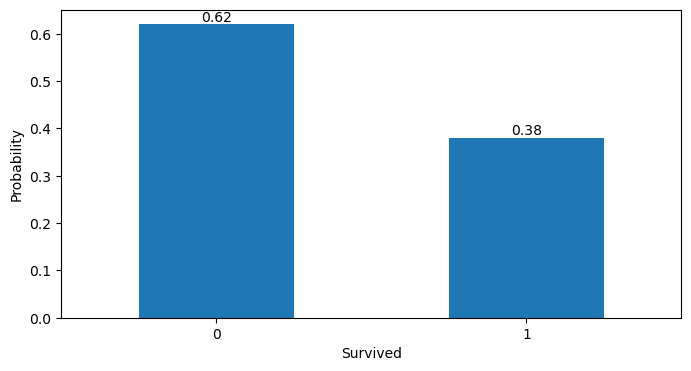

In [89]:
# Check the percentages of passengers taht survived
fig, ax = plt.subplots(figsize=(8, 4))
(df_train.groupby(["Survived"])["Survived"].count()/df_train.shape[0]).round(2).plot.bar(rot=0, ax=ax)
ax.bar_label(ax.containers[0])
ax.set_ylabel("Probability")
ax.set_xlabel("Survived")
plt.show()

We see that the majority of passengers, i.e. the 62%, did not survive.

Sex mapping: {'female': 0, 'male': 1}
Embarked mapping: {'C': 0, 'Q': 1, 'S': 2}


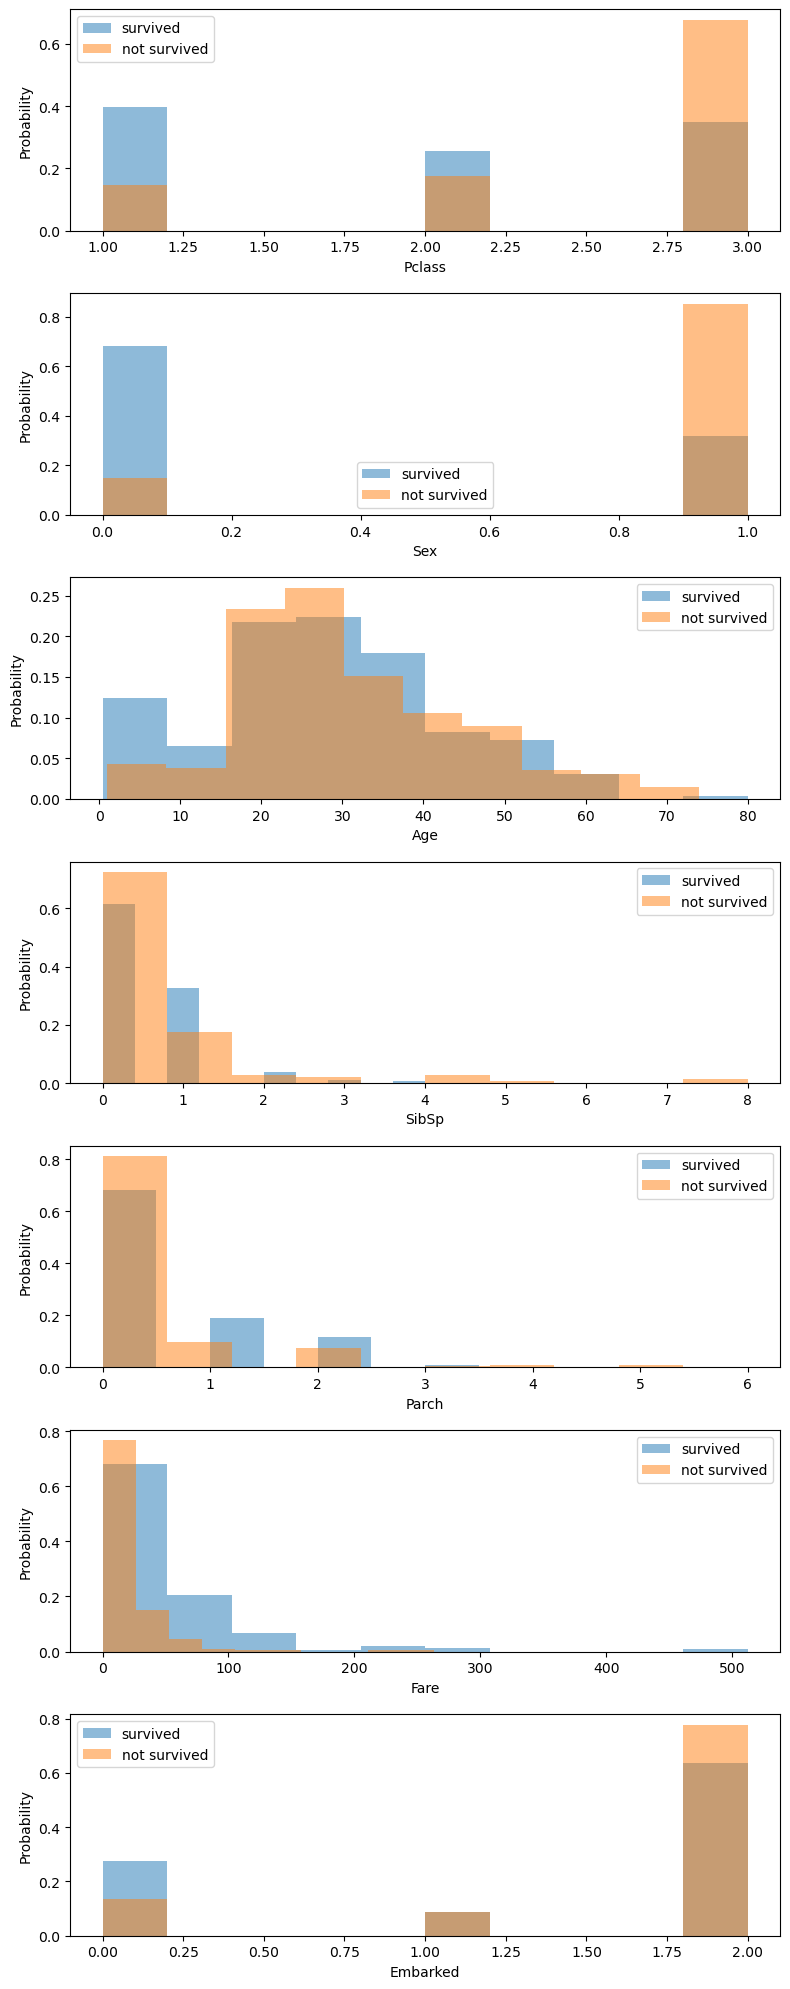

In [90]:
# Check distributions (train set, survived vs not survived)
cols = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
fig, axes = plt.subplots(len(cols), 1, figsize=(8, 20))
axes = axes.flatten()
for i, c in enumerate(cols):
    ax = axes[i]
    survived = df_train[df_train["Survived"] == 1][c].copy()
    not_survived = df_train[df_train["Survived"] == 0][c].copy()
    survived.dropna(inplace=True)
    not_survived.dropna(inplace=True)
    survived_weights = np.ones(len(survived)) / len(survived)
    not_survived_weights = np.ones(len(not_survived)) / len(not_survived)
    if c in ["Sex", "Embarked"]:
        le = LabelEncoder()
        pd.Series(le.fit_transform(survived)).plot.hist(rot=0, ax=ax, label="survived", alpha=0.5, weights=survived_weights)
        pd.Series(le.fit_transform(not_survived)).plot.hist(rot=0, ax=ax, label="not survived", alpha=0.5, weights=not_survived_weights)
        mapping = {cl: le.transform([cl])[0] for cl in le.classes_}
        print(f"{c} mapping:", mapping)
    else:
        survived.plot.hist(rot=0, ax=ax, label="survived", alpha=0.5, weights=survived_weights)
        not_survived.plot.hist(rot=0, ax=ax, label="not survived", alpha=0.5, weights=not_survived_weights)
    ax.set_ylabel("Probability")
    ax.set_xlabel(c)
    ax.legend()
plt.tight_layout()
plt.show()

Looking at the distributions above, we can say that:
- passengers belonging to upper classes are more likely to survive
- female passengers are more likely to survive
- 20 / 30 years old passengers are likely not to survive, while children are likely to survive
- passengers with a one family member are more likely to survive
- passengers with higher fare are more likely to survive
- passengers embarked from Southampton are more likely not to survive, passengers embarked from Cherbourg are more likely to survive

This considerations of course do not take into account possible correlations and dependencies among features. In principle, they should be revisisted once these are studied in more detail. 

Sex mapping: {'female': 0, 'male': 1}
Embarked mapping: {'C': 0, 'Q': 1, 'S': 2}


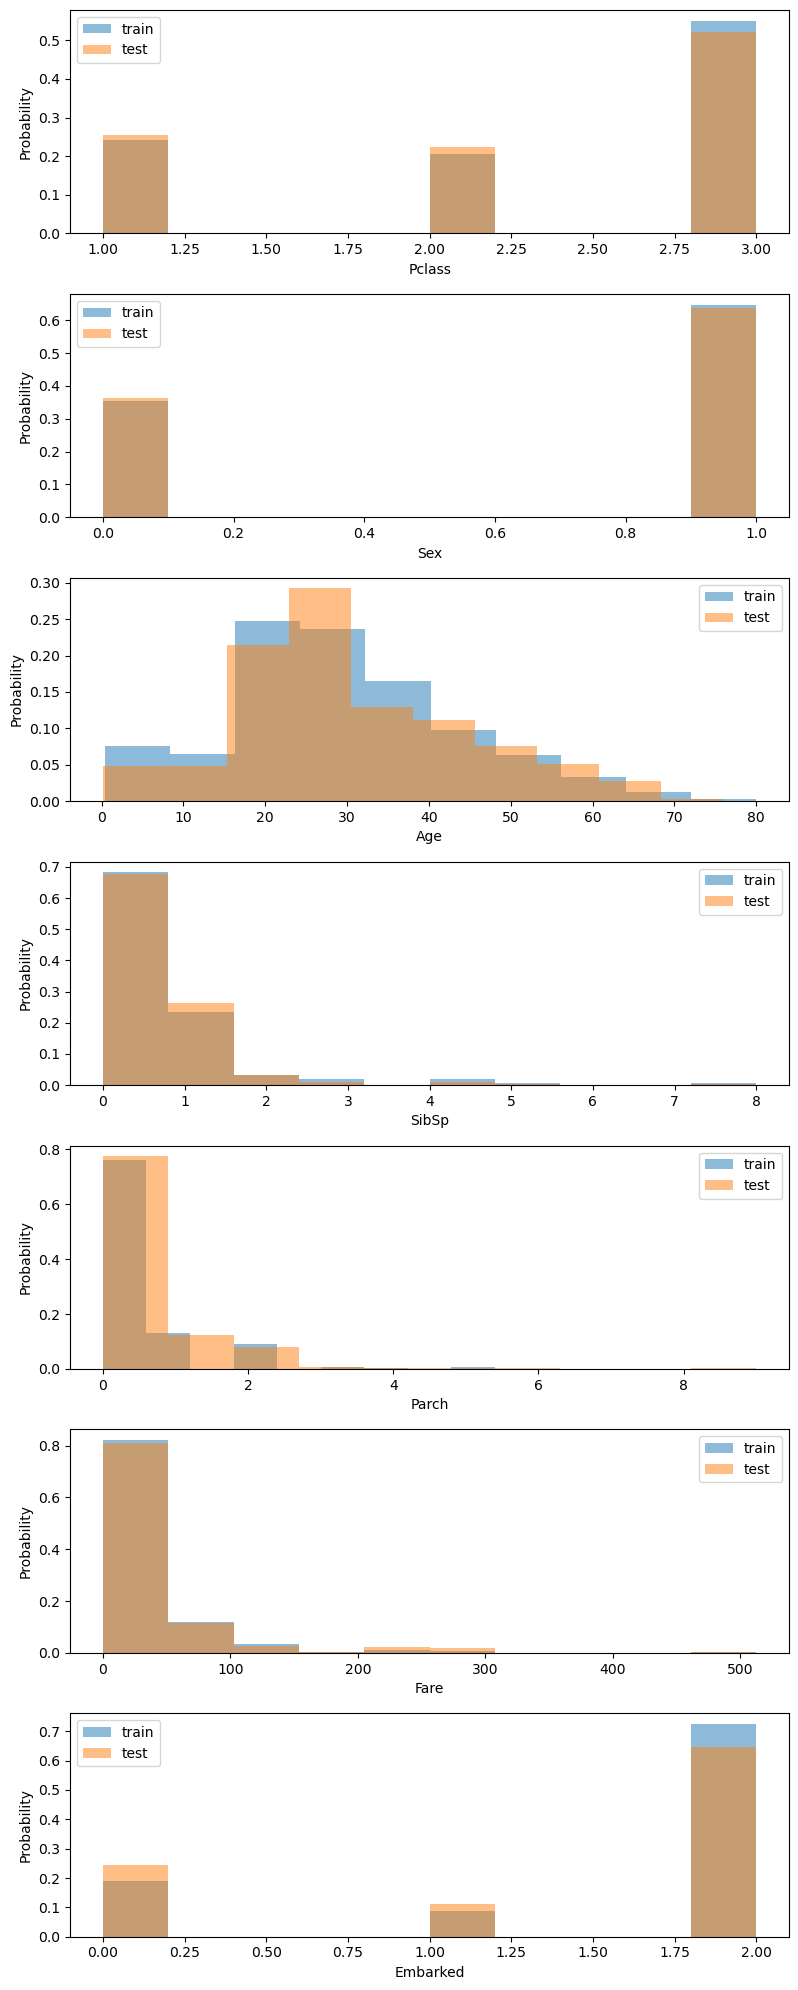

In [91]:
# Check distributions (train vs test)
cols = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
fig, axes = plt.subplots(len(cols), 1, figsize=(8, 20))
axes = axes.flatten()
for i, c in enumerate(cols):
    ax = axes[i]
    train = df_train[c].copy()
    test = df_test[c].copy()
    train.dropna(inplace=True)
    test.dropna(inplace=True)
    train_weights = np.ones(len(train)) / len(train)
    test_weights = np.ones(len(test)) / len(test)
    if c in ["Sex", "Embarked"]:
        le = LabelEncoder()
        pd.Series(le.fit_transform(train)).plot.hist(rot=0, ax=ax, label="train", alpha=0.5, weights=train_weights)
        pd.Series(le.fit_transform(test)).plot.hist(rot=0, ax=ax, label="test", alpha=0.5, weights=test_weights)
        mapping = {cl: le.transform([cl])[0] for cl in le.classes_}
        print(f"{c} mapping:", mapping)
    else:
        train.plot.hist(rot=0, ax=ax, label="train", alpha=0.5, weights=train_weights)
        test.plot.hist(rot=0, ax=ax, label="test", alpha=0.5, weights=test_weights)
    ax.set_ylabel("Probability")
    ax.set_xlabel(c)
    ax.legend()
plt.tight_layout()
plt.show()

Looking at the plots above, we see that train and test distributions are very close to each other.

Let's have a look at the correlation among the features and the target.

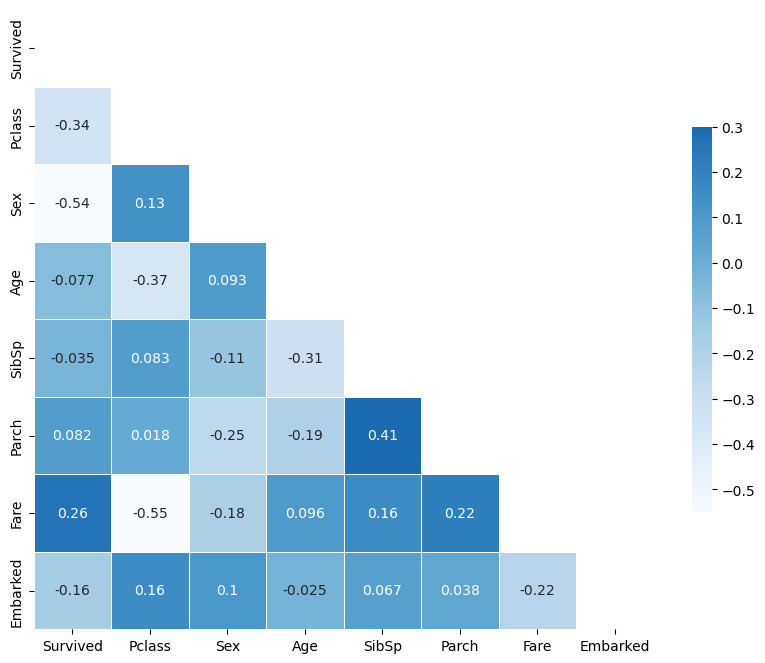

In [92]:
# Make copy of df train
tmp = df_train.copy()

# Label encode Sex and embarked features
tmp["Sex"] = LabelEncoder().fit_transform(tmp["Sex"])
tmp["Embarked"] = LabelEncoder().fit_transform(tmp["Embarked"])

# Compute the correlation matrix
corr = tmp.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.3, center=0, cmap="Blues", annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

From the above heatmap, we can see that:
- Survived anti-correlates with Pclass, Sex and correlates with Fare (passengers belonging to upper classes and female passengers are more likely to survive)
- Pclass anti-correlate with Age and Fare (passengers belonging to upper classes tend to be older and tend to pay the tickets more)
- Age anti-correlates with SibSp
- SibSp correlates with Parch (passengers with a spouse, siblings tend to have bigger families)
- Parch correlates with Fare (families pay more to buy all their tickets)

## 1.2 Missing Data

In [93]:
# Let's print info abpout the datasets
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [94]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


We see that there are missing values in *Age*, *Cabin* and *Embarked* columns in training set and *Age*, *Cabin* and *Fare* in test set. Let's use concatenated train and test sets to study missing data. In this way we avoid filled data to overfit to train or test samples.

### 1.2.1 Age

Let's check how Age is related to other features. We don't check the relation with the target because we cannot use it to reconstruct the missing values in the test set. We do not check *Name* and *Ticket* because of the huge number of distinct values. We do not check *Cabin* because of the huge number of missing values.  

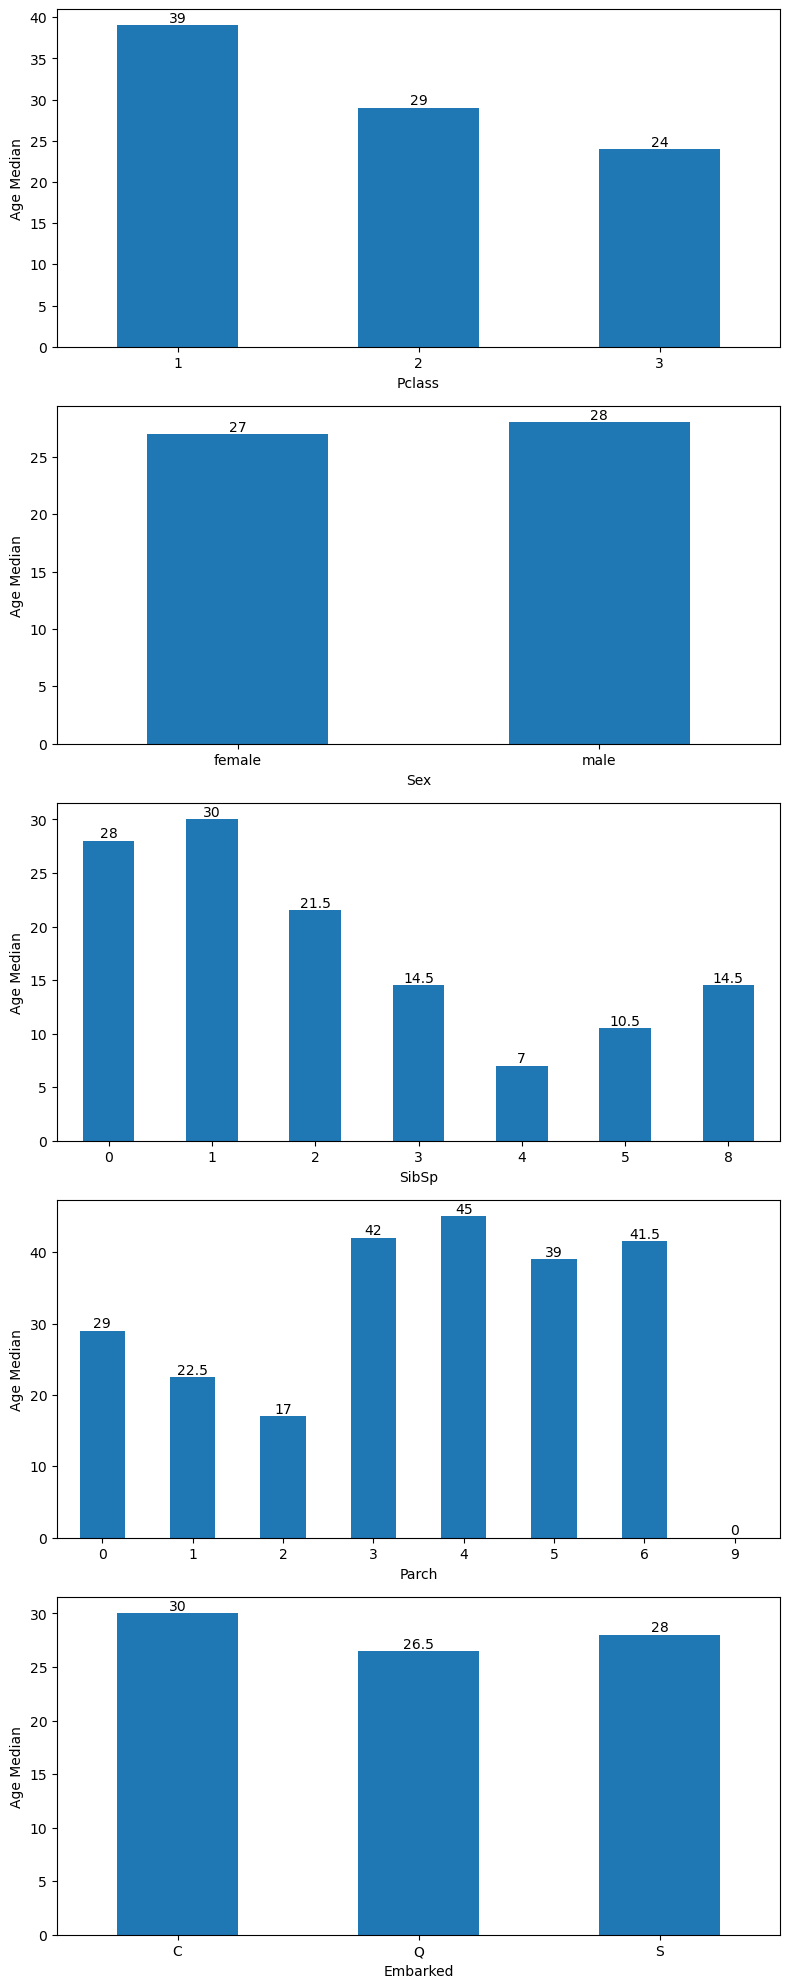

In [95]:
cols = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]
fig, axes = plt.subplots(len(cols), 1, figsize=(8, 20))
axes = axes.flatten()
for i, c in enumerate(cols):
    ax = axes[i]
    df.groupby(c)["Age"].median().plot.bar(rot=0, ax=ax)
    ax.set_ylabel("Age Median")
    ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

We see that we can use *Pclass* and *Sex* to reconstruct the missing data. Let's further investigate the relation between these two features and age.

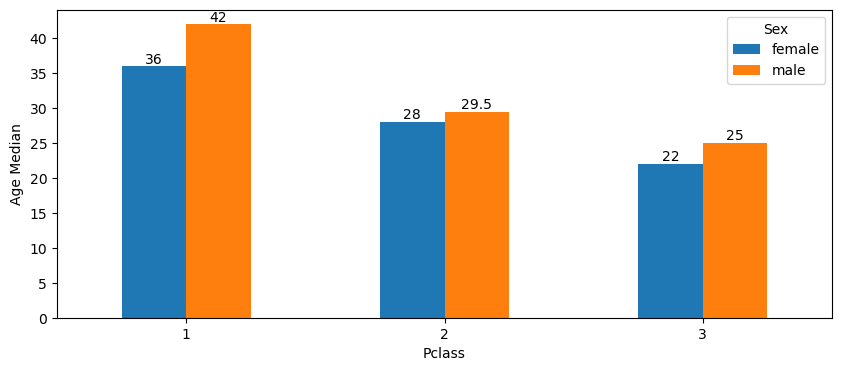

In [96]:
fig, ax = plt.subplots(figsize=(10, 4))
df.groupby(["Sex", "Pclass"])["Age"].median().unstack(level=0).plot.bar(rot=0, ax=ax)
ax.set_ylabel("Age Median")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

Let's now impute the missing values

In [97]:
df["Age"] = df.groupby(['Sex', 'Pclass'], group_keys=False)['Age'].apply(lambda x: x.fillna(x.median()))

### 1.2.2 Embarked

In [98]:
df[df["Embarked"].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
62,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,1,female,0,1.0,113572
830,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,1,female,0,1.0,113572


We have just two missing values for *Embarked*. In principle, we can use the mode of *Embarked* for upper class female passengers to fill these values. However, it turns out that we can retrieve this information by googling the names of the passengers. Both of them embarked from Southampton, so we are going to fill these missing values with *S*.

In [99]:
df["Embarked"].fillna("S", inplace=True)

### 1.2.3 Fare

In [100]:
df[df["Fare"].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1044,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,3,male,0,NaN,3701


We can impute this value by assuming that the fare of the ticket is dependent by the class *Pclass* and the family size, i.e. *Parch* + *SibSp*

In [101]:
df["Fare"].fillna(df.groupby(["Pclass", "Parch", "SibSp"])["Fare"].median()[3][0][0], inplace=True)

### 1.2.4 Cabin

*Cabin* has a lot of missing values (almost 80% of the values), however it cannot be discarded because it is linked to the decks where passengers were located on the ship. It is reasonable therefore to assume that there's a link between this feature and the target and to further investigate it. In particular, we can create the feature *Deck* by discarding the numbers and keeping only the first letter in the *Cabin* feature. We will collect all the missing values under an assigned deck call *NA*.

In [102]:
df["Cabin"].fillna("NA", inplace=True)
df["Deck"] = df["Cabin"].apply(lambda x: x[0] if x != "NA" else x)

Let's check the relation between *Deck* and *Pclass* and *Deck* and *Survived*

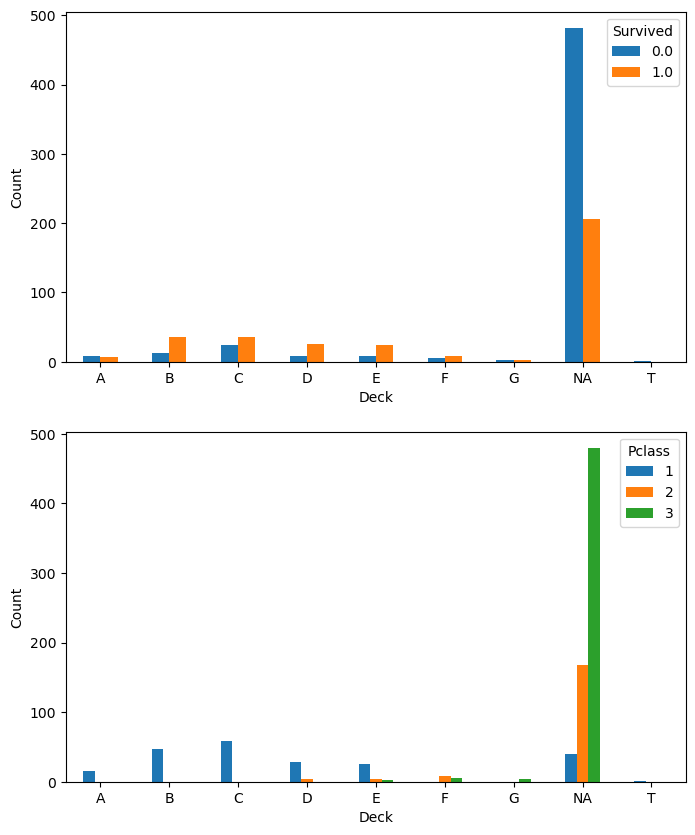

In [103]:
cols = ["Survived", "Pclass"]
fig, axes = plt.subplots(len(cols), 1, figsize=(8, 10))
axes = axes.flatten()
for i, c in enumerate(cols):
    ax = axes[i]
    df.groupby(["Deck", c])["Survived"].count().unstack(level=1).plot.bar(rot=0, ax=ax)
    ax.set_ylabel("Count")
plt.show()

We see that survival rate and passengers class differ considerably from deck to deck. More specifically, we see that cabins occupied by passengers with upper classes show an higher survival rate.

Let's check that we have filled all the missing values succesfully.

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       1309 non-null   float64
 1   Cabin     1309 non-null   object 
 2   Embarked  1309 non-null   object 
 3   Fare      1309 non-null   float64
 4   Name      1309 non-null   object 
 5   Parch     1309 non-null   int64  
 6   Pclass    1309 non-null   int64  
 7   Sex       1309 non-null   object 
 8   SibSp     1309 non-null   int64  
 9   Survived  891 non-null    float64
 10  Ticket    1309 non-null   object 
 11  Deck      1309 non-null   object 
dtypes: float64(3), int64(3), object(6)
memory usage: 132.9+ KB


In [105]:
# Let's drop the useless feature Cabin
df.drop("Cabin", axis=1, inplace=True)

# 2. Feature Engineering

We first deal with continuous features *Age* and *Fare*. Since we are going to use a random forest to make predictions on test set, we bin these features to improve performances. We do some trial and error and check how survival rate changes among different binning choices to select the one that seems to give the highest information gain. 

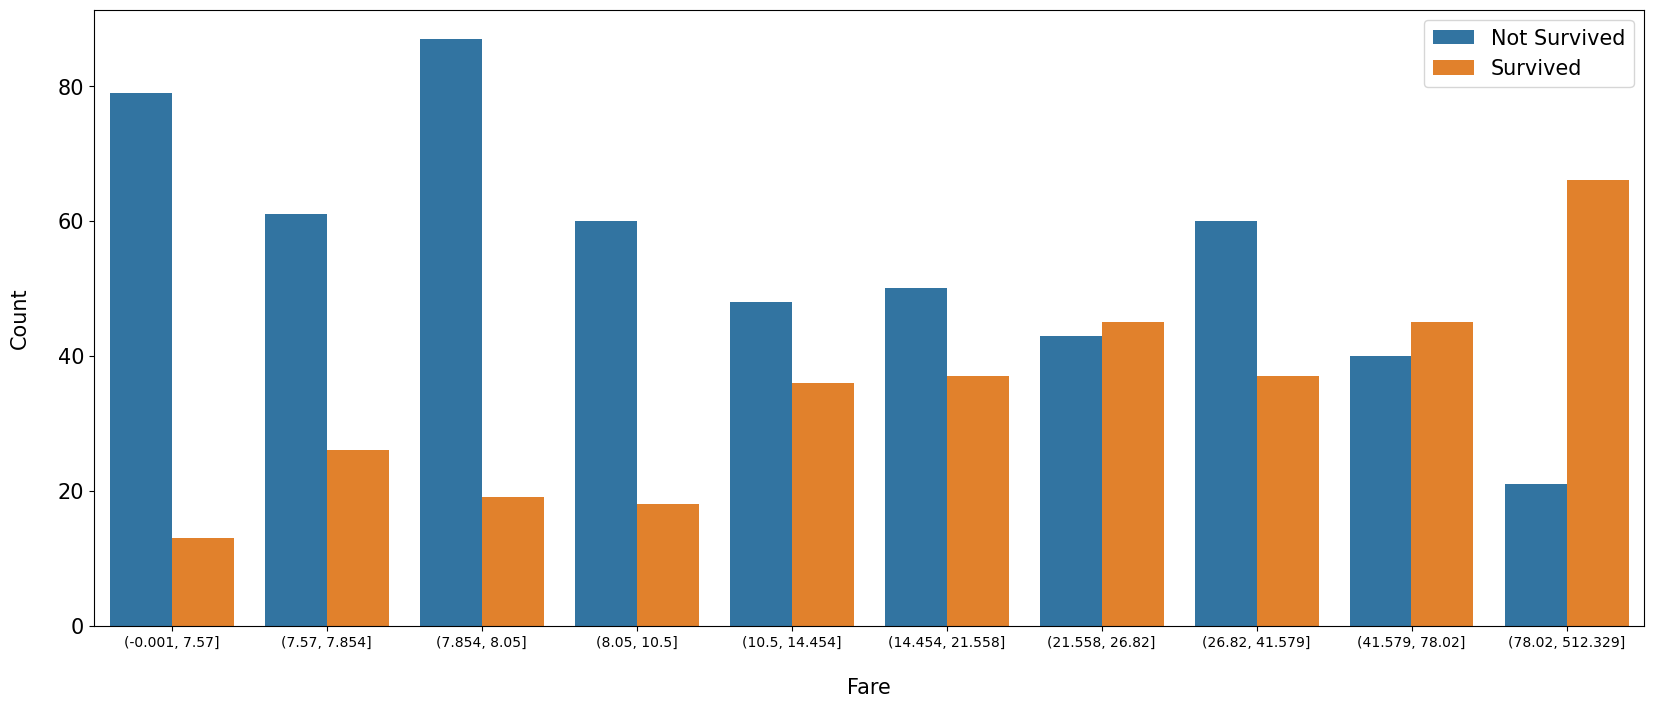

In [106]:
# Binning Fare feature
df["Fare"] = pd.qcut(df['Fare'], 10)

# Plot
fig, ax = plt.subplots(figsize=(20, 8))
sns.countplot(x='Fare', hue='Survived', data=df)
plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)
plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.show()

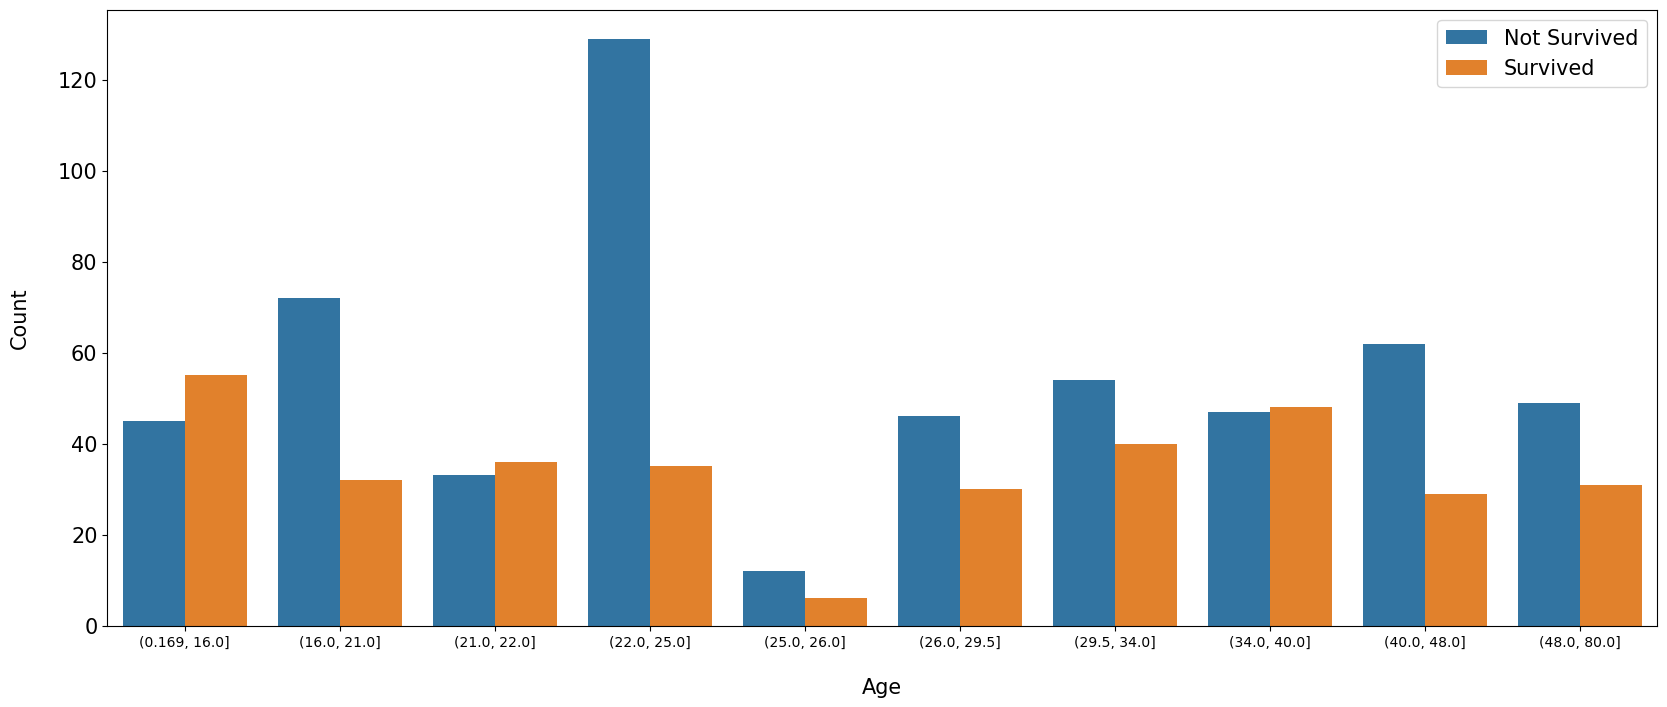

In [107]:
# Binning Fare feature
df["Age"] = pd.qcut(df['Age'], 10)

# Plot
fig, ax = plt.subplots(figsize=(20, 8))
sns.countplot(x='Age', hue='Survived', data=df)
plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)
plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.show()

We decided for 10 bins both for *Fare* and *Age*.

Let's now try to extract useful information from the *Ticket* feature. While *SibSp* and *Parch* take into account relatives of a given passenger, friendships or other possible relations are not taken into account and might be inferred from the *Ticket* feature: it is very likely that passengers with the same tickets know each other and have embarked together. To this end, we create the *Ticket_freq* feature that counts the frequency of a given ticket. In this way we will know even better which passengers were travelling alone, with another person, in a group of 2 etc... 

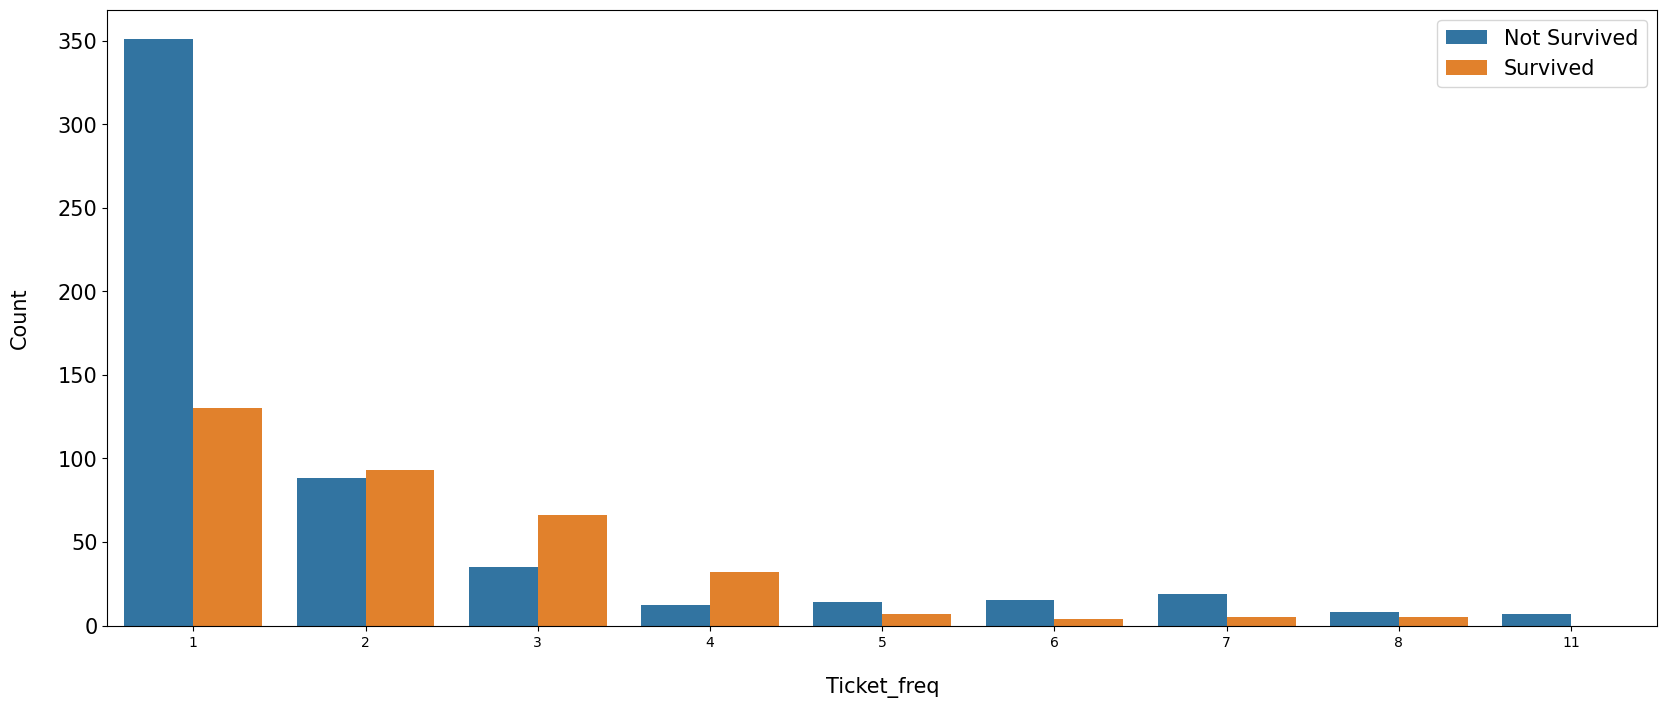

In [108]:
# Get Ticket_freq feature
df["Ticket_freq"] = df.groupby('Ticket')['Ticket'].transform('count')

# Plot
fig, ax = plt.subplots(figsize=(20, 8))
sns.countplot(x='Ticket_freq', hue='Survived', data=df)
plt.xlabel('Ticket_freq', size=15, labelpad=20)
plt.ylabel('Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)
plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.show()

According to the graph above, groups with 2, 3 and 4 members have a higher survival rate while passengers who travel alone have the lowest survival rate.


Let's now move to the *Name* feature. Here we can extract information about the title and the marital status of the passengers. Both of these might be linked to the survival probability. 

In [109]:
# Let's check the unique values and count their occurrences
df["Title"] = df["Name"].apply(lambda x: x.split(",")[1].split(".")[0])
df["Title"].value_counts()

 Mr              757
 Miss            260
 Mrs             197
 Master           61
 Rev               8
 Dr                8
 Col               4
 Mlle              2
 Major             2
 Ms                2
 Lady              1
 Sir               1
 Mme               1
 Don               1
 Capt              1
 the Countess      1
 Jonkheer          1
 Dona              1
Name: Title, dtype: int64

In [110]:
df["Title"].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer', ' Dona'], dtype=object)

In [111]:
# Let's start by investigating Master title
df[df["Title"] == " Master"]

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Deck,Ticket_freq,Title
PassengerId,,,,,,,,,,,,,
8,"(0.169, 16.0]",S,"(14.454, 21.558]","Palsson, Master. Gosta Leonard",1,3,male,3,0.0,349909,NA,5,Master
17,"(0.169, 16.0]",Q,"(26.82, 41.579]","Rice, Master. Eugene",1,3,male,4,0.0,382652,NA,6,Master
51,"(0.169, 16.0]",S,"(26.82, 41.579]","Panula, Master. Juha Niilo",1,3,male,4,0.0,3101295,NA,7,Master
60,"(0.169, 16.0]",S,"(41.579, 78.02]","Goodwin, Master. William Frederick",2,3,male,5,0.0,CA 2144,NA,8,Master
64,"(0.169, 16.0]",S,"(26.82, 41.579]","Skoog, Master. Harald",2,3,male,3,0.0,347088,NA,6,Master
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,"(0.169, 16.0]",S,"(41.579, 78.02]","Sage, Master. William Henry",2,3,male,8,NaN,CA. 2343,NA,11,Master
1271,"(0.169, 16.0]",S,"(26.82, 41.579]","Asplund, Master. Carl Edgar",2,3,male,4,NaN,347077,NA,7,Master
1281,"(0.169, 16.0]",S,"(14.454, 21.558]","Palsson, Master. Paul Folke",1,3,male,3,NaN,349909,NA,5,Master


In [112]:
# Let's move to Rev, Dr, Col, Major, Jonkheer, Capt, Sir, Don
df[df["Title"].isin([' Don', ' Rev', ' Dr', ' Major', ' Sir', ' Col', ' Capt',' Jonkheer'])]

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Deck,Ticket_freq,Title
PassengerId,,,,,,,,,,,,,
31,"(34.0, 40.0]",C,"(26.82, 41.579]","Uruchurtu, Don. Manuel E",0,1,male,0,0.0,PC 17601,NA,1,Don
150,"(40.0, 48.0]",S,"(10.5, 14.454]","Byles, Rev. Thomas Roussel Davids",0,2,male,0,0.0,244310,NA,1,Rev
151,"(48.0, 80.0]",S,"(10.5, 14.454]","Bateman, Rev. Robert James",0,2,male,0,0.0,S.O.P. 1166,NA,1,Rev
246,"(40.0, 48.0]",Q,"(78.02, 512.329]","Minahan, Dr. William Edward",0,1,male,2,0.0,19928,C,3,Dr
250,"(48.0, 80.0]",S,"(21.558, 26.82]","Carter, Rev. Ernest Courtenay",0,2,male,1,0.0,244252,NA,2,Rev
318,"(48.0, 80.0]",S,"(10.5, 14.454]","Moraweck, Dr. Ernest",0,2,male,0,0.0,29011,NA,1,Dr
399,"(22.0, 25.0]",S,"(8.05, 10.5]","Pain, Dr. Alfred",0,2,male,0,0.0,244278,NA,1,Dr
450,"(48.0, 80.0]",S,"(26.82, 41.579]","Peuchen, Major. Arthur Godfrey",0,1,male,0,1.0,113786,C,1,Major
537,"(40.0, 48.0]",S,"(21.558, 26.82]","Butt, Major. Archibald Willingham",0,1,male,0,0.0,113050,B,1,Major


Looking at the passengers characteristics, it sounds reasonable to group the titles in 4 distinct groups:
- Mr (0)
- Miss/Mrs/Ms (1)
- Master (2)
- Noble (3)
Before we also exploit the *Mrs* information to create the feature *Is_Married* that might be linked with an higher survival rate.

In [113]:
# Create Is_Married feature
df["Is_Married"] = 0
df.loc[df["Title"] == " Mrs", "Is_Married"] = 1

# Perform title replacements
df["Title"] = df["Title"].replace([' Mr'], 0)
df["Title"] = df["Title"].replace([' Mrs', ' Miss', ' Ms', ' Mme', ' Lady', ' Mlle',' the Countess', ' Dona'], 1)
df["Title"] = df["Title"].replace([' Master'], 2)
df["Title"] = df["Title"].replace([' Don', ' Rev', ' Dr', ' Major', ' Sir', ' Col', ' Capt',' Jonkheer'], 3)
df["Title"].unique()

array([0, 1, 2, 3], dtype=int64)

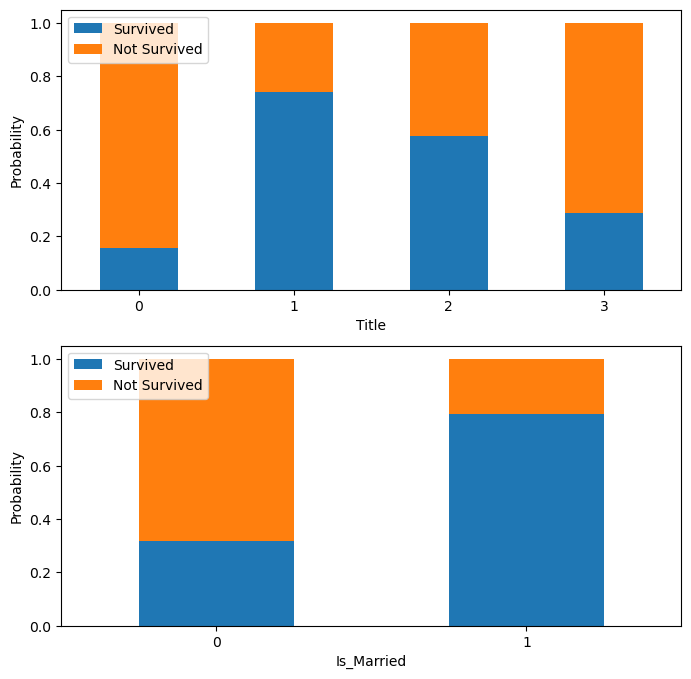

In [159]:
# Check the distribution of the target among the new features
tmp = df.loc[df_train.index].copy()
cols = ["Title", "Is_Married"]
fig, axes = plt.subplots(len(cols), 1, figsize=(8, 8))
axes = axes.flatten()
for i, c in enumerate(cols):
    ax = axes[i]
    gtmp = (tmp.groupby(c)[["Survived"]].sum() / tmp.groupby(c)[["Survived"]].count())
    gtmp["Not Survived"] = 1 - gtmp["Survived"]
    gtmp.plot.bar(stacked=True, rot=0, ax=ax)
    ax.set_ylabel("Probability")
    ax.set_xlabel(c)
    ax.legend(loc=2)
plt.show()

From the plots above we see indeed that the *Name* feature contains valuable information:
- Ms/Miss/Mrs and Master groups are more likely to survive
- Married women are more likely to survive

## 4. References

- https://www.kaggle.com/competitions/titanic/overview
- https://www.kaggle.com/code/surenvayradyan/top-1-realscores-vayradyan-s-titanic
- https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial
- https://www.kaggle.com/code/andreynesterov/titanic-predictions